In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [25]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine, reflect=True)
# reflect the tables



C:\Users\matth\AppData\Local\Temp\ipykernel_10624\1337372429.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(autoload_with=engine, reflect=True)


In [27]:
# View all of the classes that automap found
print(Base.classes.keys())


['station', 'measurement']


In [28]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [30]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date

'2017-08-23'

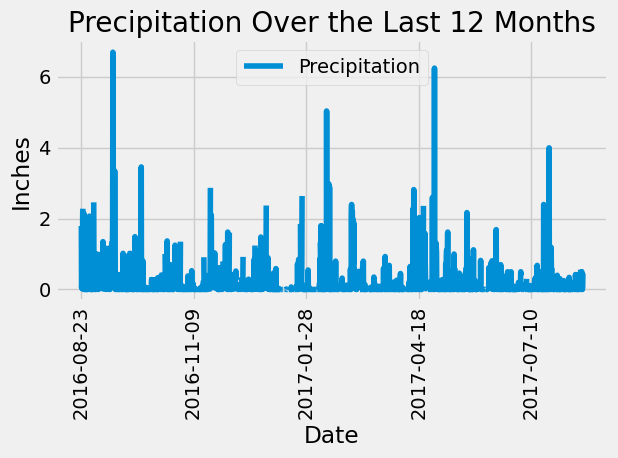

In [60]:
# Design a query to retrieve the last 12 months of precipitation data
# Calculate the date one year from the last date in data set.
one_year_ago = (pd.to_datetime(recent_date) - pd.DateOffset(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .filter(Measurement.date <= recent_date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Plot the data using the DataFrame plot method
ax = precipitation_df.plot(x='Date', y='Precipitation', title='Precipitation Over the Last 12 Months', rot=90)
ax.set_xlabel('Date')
ax.set_ylabel('Inches')

plt.tight_layout()
plt.show()

In [61]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate summary statistics for precipitation data
precip_desc_df = pd.DataFrame(precipitation_df['Precipitation'].describe())
precip_desc_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).scalar()


9

In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .first()[0]
# Query to calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .all()

# Extract the result
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Display the result
print(lowest_temp, highest_temp, avg_temp)

54.0 85.0 71.66378066378067


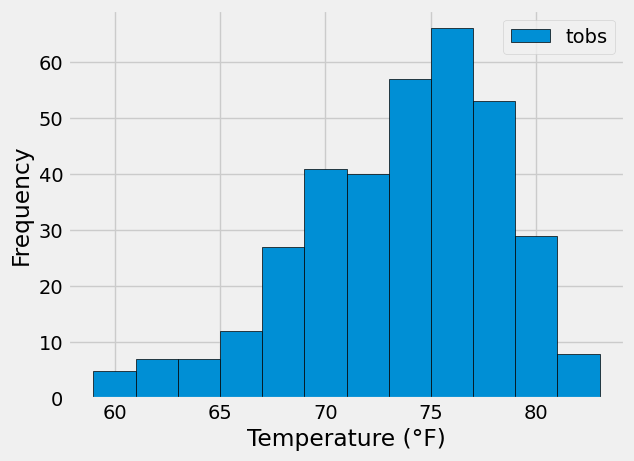

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date in the dataset
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()

# Convert most_recent_date_str to a datetime object
most_recent_date = pd.to_datetime(most_recent_date_str)

# Calculate the date one year ago from the most recent date
one_year_ago = (most_recent_date - pd.DateOffset(days=365)).strftime('%Y-%m-%d')

# Query temperature observation data for the last 12 months for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= one_year_ago)\
    .filter(Measurement.date <= most_recent_date_str)\
    .all()

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.hist(temperature_df['Temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()


# Close Session

In [ ]:
# Close Session
session.close()